Set up connection between Colab & GG Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data visualize

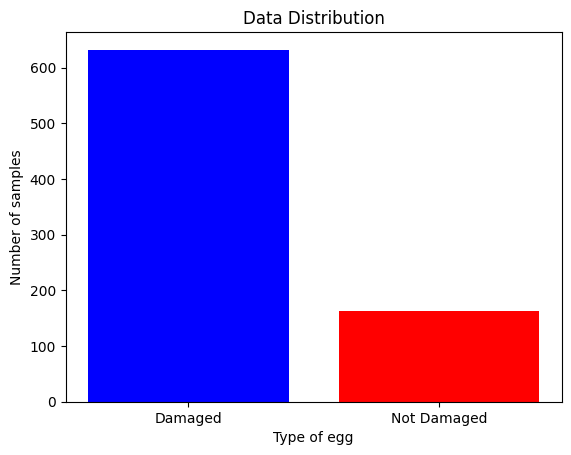

{'Damaged': 632, 'Not Damaged': 162}


In [2]:
import os
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/Data/eggs"
classes = ['Damaged', 'Not Damaged']

counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

plt.bar(counts.keys(), counts.values(), color=["blue", "red"])
plt.title("Data Distribution")
plt.xlabel("Type of egg")
plt.ylabel("Number of samples")
plt.show()

print(counts)

Split data

In [3]:
import os, shutil, random

if os.path.exists('data_split'):
    shutil.rmtree('data_split')

base_dir = '/content/drive/MyDrive/Data/eggs'
classes = ['Not Damaged', 'Damaged']

# Create target dictionary
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join('data_split', split, cls), exist_ok=True)

# Ratio
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

for cls in classes:
    src_dir = os.path.join(base_dir, cls)
    imgs = os.listdir(src_dir)
    random.shuffle(imgs)

    total = len(imgs)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    # Chia file
    for i, img in enumerate(imgs):
        src = os.path.join(src_dir, img)
        if i < train_end:
            dst = os.path.join('data_split/train', cls, img)
        elif i < val_end:
            dst = os.path.join('data_split/val', cls, img)
        else:
            dst = os.path.join('data_split/test', cls, img)
        shutil.copy(src, dst)

In [4]:
import tensorflow as tf

BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/train",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = None,
    shuffle = True
)

normal_set = train_set.filter(lambda x, y: tf.squeeze(tf.equal(y, 1)))
broken_set = train_set.filter(lambda x, y: tf.squeeze(tf.equal(y, 0)))
normal_set = normal_set.repeat(4)

balanced_train = normal_set.concatenate(broken_set)
balanced_train = balanced_train.shuffle(2000).batch(BATCH_SIZE)

test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/test",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

val_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/val",
    label_mode = "binary",
    color_mode = "rgb",
    seed = 42,
    image_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

class_names = train_set.class_names
print("Class names:", class_names)

for x, y in balanced_train.take(1):
    print(x.shape)

Found 555 files belonging to 2 classes.
Found 81 files belonging to 2 classes.
Found 158 files belonging to 2 classes.
Class names: ['Damaged', 'Not Damaged']
(32, 128, 128, 3)


/tmp/ipython-input-3479255070.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts[int(labels.numpy())] += 1


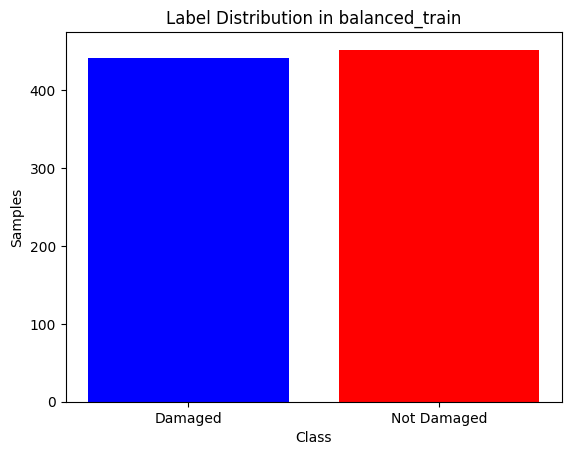

{0: 442, 1: 452}


In [ ]:
import numpy as np

label_counts = {0: 0, 1: 0}
for _, labels in balanced_train.take(2000):  # lấy mẫu 2000 ảnh để thống kê
    label_counts[int(labels.numpy())] += 1

plt.bar(['Damaged', 'Not Damaged'], label_counts.values(), color=["blue", "red"])
plt.title("Label Distribution in balanced_train")
plt.xlabel("Class")
plt.ylabel("Samples")
plt.show()

print(label_counts)

balanced_train = balanced_train.shuffle(2000).batch(BATCH_SIZE).repeat()

Build Model CNN

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomBrightness(factor=0.1),
])

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=['accuracy']
)

history = model.fit(
    balanced_train,
    validation_data=val_set,
    epochs=15
  )

Epoch 1/15
     28/Unknown 76s 939ms/step - accuracy: 0.4989 - loss: 1.8047

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.4995 - loss: 1.7809 - val_accuracy: 0.4747 - val_loss: 0.7150
Epoch 2/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6613 - loss: 0.6284 - val_accuracy: 0.7848 - val_loss: 0.5433
Epoch 3/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6981 - loss: 0.6064 - val_accuracy: 0.7405 - val_loss: 0.6448
Epoch 4/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7166 - loss: 0.5702 - val_accuracy: 0.7468 - val_loss: 0.6472
Epoch 5/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6490 - loss: 0.6153 - val_accuracy: 0.7911 - val_loss: 0.5456
Epoch 6/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.6929 - loss: 0.5694 - val_accuracy: 0.6076 - val_loss: 0.9227
Epoch 7/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7089 - loss: 0.5376 - val_accuracy: 0.7785 - val_loss: 0.5474
Epoch 8/15
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7660 - loss: 0.4703 - val_accuracy: 0.7405 - val_loss: 0.5946
Epo

In [19]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Accuracy on test set: {test_accuracy:.2%}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.9428 - loss: 0.2007
Accuracy on test set: 90.12%


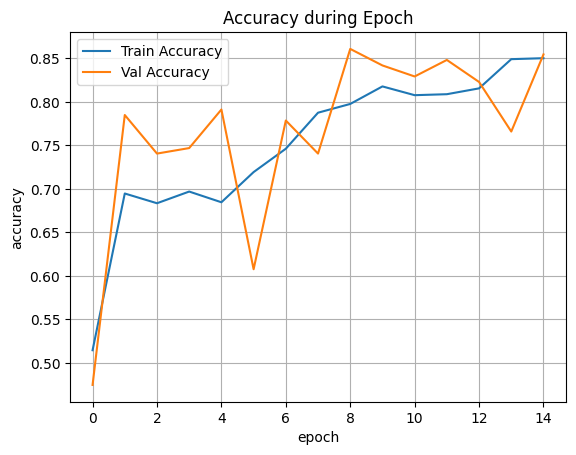

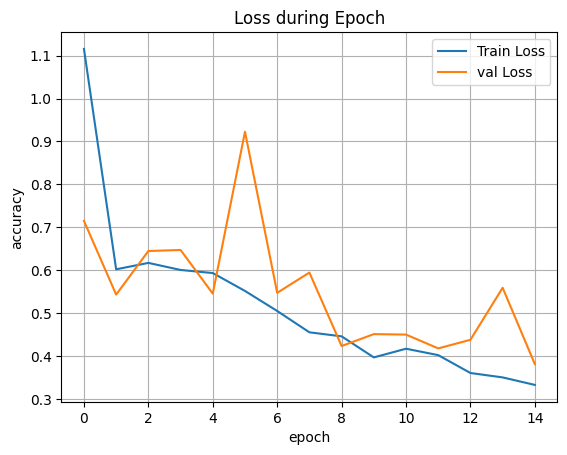

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.title("Accuracy during Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="val Loss")
plt.title("Loss during Epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.grid(True)
plt.show()

Evaluation

In [21]:
import numpy as np

def predict_image(img_path, img_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])):
  img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=img_size)
  img_array = tf.keras.utils.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)[0][0]
  pred_class = 1 if prediction >= 0.5 else 0
  label = class_names[pred_class]

  confidence = prediction if pred_class ==1 else (1-prediction)

  print(f"Prediction: {label} ({prediction:.2f}) | Confidence: {confidence*100:.2f}%")

  plt.imshow(img, cmap='gray')
  plt.title(f"Model Predict: {label}\nConfidence: ({confidence*100:.2f})%")
  plt.axis("off")
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Prediction: Not Damaged (0.68) | Confidence: 67.97%


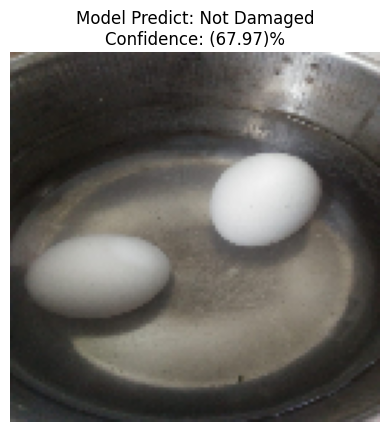

In [30]:
predict_image("/content/data_split/test/Not Damaged/not_damaged_114.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Prediction: Damaged (0.10) | Confidence: 90.48%


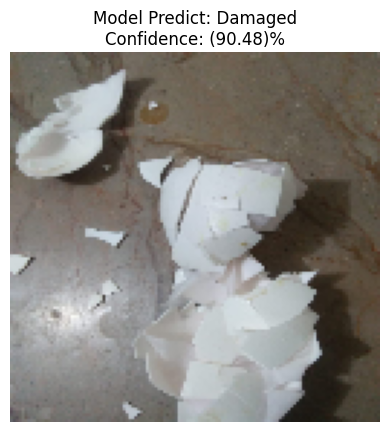

In [25]:
predict_image("/content/data_split/test/Damaged/damaged_102.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Prediction: Damaged (0.03) | Confidence: 97.42%


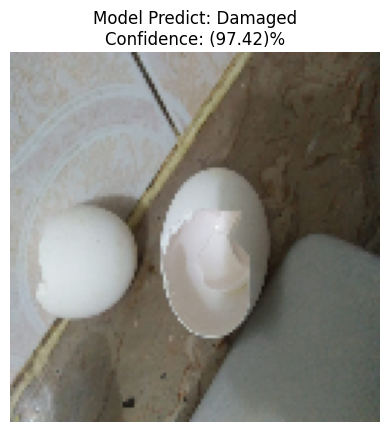

In [26]:
predict_image("/content/data_split/test/Damaged/damaged_136.jpg")

tính F1  score, precision